In [1]:
import numpy as np  # For numerical computations
from scipy.optimize import minimize  # For numerical optimization
from sklearn.datasets import make_regression  # For generating synthetic datasets
from sklearn.linear_model import LinearRegression, Ridge  # For linear and ridge regression
from sklearn.preprocessing import PolynomialFeatures  # For polynomial feature generation
from sklearn.metrics import mean_squared_error  # For calculating mean squared error
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced visualizations

import einops  # For tensor operations

# Synthetic Data Generation

X shape: (2502, 1)
y shape: (2502,)


<Axes: title={'center': 'Synthetic Data'}, xlabel='X', ylabel='y'>

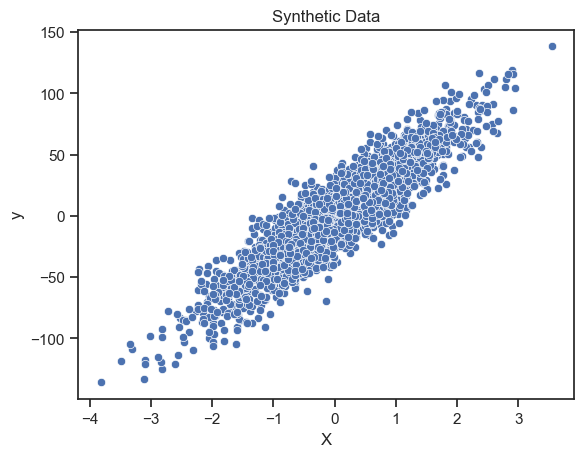

In [21]:
X, y = make_regression(n_samples=2502, n_features=1, noise=16, random_state=259202)

print("X shape:", X.shape) # X is N samples by D features [N,D]
print("y shape:", y.shape) # y is N samples [N,]

# plt.scatter(X, y, alpha=0.4, label='Data points')
# plt.legend()
# plt.show()
sns.set_context("notebook")
sns.set_style("ticks")
plt.xlabel('X')
plt.ylabel('y')
plt.title('Synthetic Data')
sns.scatterplot(x=X.flatten(),y=y)

# Analytical Linear Regression
Formula: w = (X^T X)^(-1) X^T y

w = [2,N] @ [N,2] = [2,2] ^ -1 -> [2,2] @ [2,N] = [2,N] -> [2,N] @ [N,] = [2,]


In [47]:
def analytical_linear_regression(X, y):

    X_ = np.c_[np.ones(X.shape[0]), X] # [N, D+1]

    w = np.linalg.inv(X_.T @ X_) @ X_.T @ y
    return w


weights = analytical_linear_regression(X, y)
print("w:", weights)

w: [-0.05959016 35.32283381]


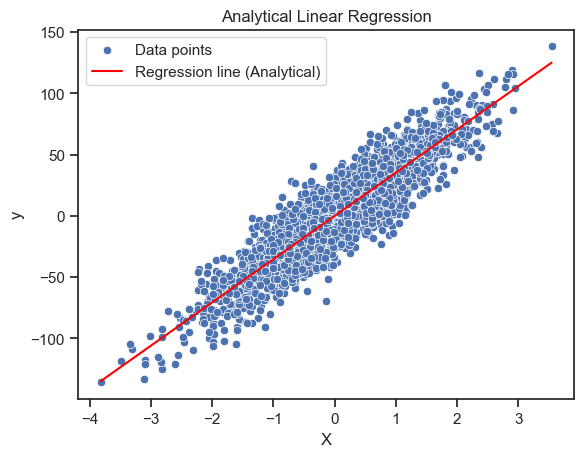

In [57]:
ones = np.ones(X.shape[0]) # [N,]
X_ = np.column_stack((ones, X)) 
y_pred = X_ @ weights

sns.set_context("notebook")
sns.set_style("ticks")
plt.xlabel('X')
plt.ylabel('y')
plt.title('Analytical Linear Regression')
sns.scatterplot(x=X.flatten(), y=y, label='Data points')
sns.lineplot(x=X.flatten(), y=y_pred, color='red', label='Regression line (Analytical)')
plt.legend()
plt.show()

# Numerical Linear Regression
Loss function L(w) = (1/N) * (y - X^T w)^T * (y - X^T w).

In [58]:
def loss_function(w, X, y):

    # [N, D+1] = [2502, 2]
    X_ = np.c_[np.ones(X.shape[0]), X] 
    
    y_pred = X_ @ w
    residuals = y - y_pred
    
    N = len(y)        
    loss = (1 / N) * (residuals.T @ residuals)

    return loss


result = minimize(
    fun=loss_function,
    x0=[100,-50],
    args=(X, y),
    method='Powell'
)

numerical_weights = result.x

print("w:", numerical_weights)
print("Iterations:", result.nit)
print("Evaluations", result.nfev)

w: [-0.05959002 35.32283381]
Iterations: 3
Evaluations 117


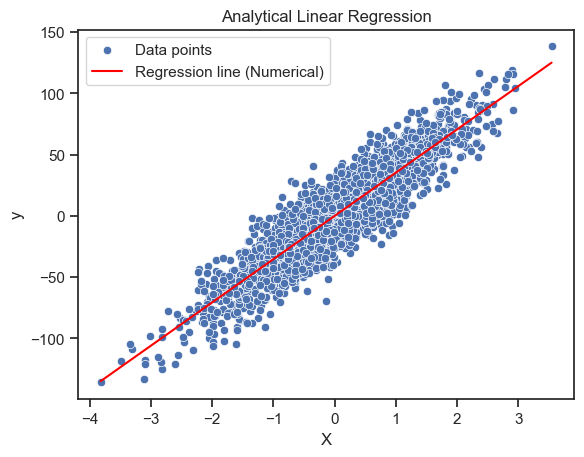

In [59]:
X_ = np.c_[np.ones(X.shape[0]), X]
y_pred_numerical = X_ @ numerical_weights

sns.set_context("notebook")
sns.set_style("ticks")
plt.xlabel('X')
plt.ylabel('y')
plt.title('Analytical Linear Regression')
sns.scatterplot(x=X.flatten(), y=y, label='Data points')
sns.lineplot(x=X.flatten(), y=y_pred_numerical, color='red', label='Regression line (Numerical)')
plt.legend()
plt.show()

In [63]:
import time

start_time = time.time()
for _ in range(1000):
    analytical_weights = analytical_linear_regression(X, y)
analytical_time = time.time() - start_time

start_time = time.time()
for _ in range(1000): 
    result = minimize(fun=loss_function, x0=[0,0], args=(X, y), method='Powell')
    numerical_weights = result.x
numerical_time = time.time() - start_time

print(f"Analytical time: {analytical_time:.6f} s")
print(f"Numerical time: {numerical_time:.6f} s")
print(f"Analitycal method is : {numerical_time/analytical_time:.2f}x faster than numerical method")

Analytical time: 0.163035 s
Numerical time: 0.984928 s
Analitycal method is : 6.04x faster than numerical method
